In [32]:
import pandas as pd
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling 
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
tada_eta = tada_eta.sample(frac=1, random_state = 0). reset_index(drop=True)

distance = ((tada_eta["pickup_lng"]- tada_eta["driver_lng"])**2 +(tada_eta["pickup_lat"]- tada_eta["driver_lat"])**2)*10000
tada_eta["distance"] = distance
tada_eta.drop(["id","pickup_lng","pickup_lat","driver_id","driver_lng","driver_lat","created_at_kst","pickup_gu"], axis=1, inplace=True)
tada_eta.head()

col = tada_eta.columns
for col in tada_eta.columns:
  print(f"{col}  {type(tada_eta.loc[0][col])}")

#tada_eta["pickup_gu"].unique()
#pg = list(tada_eta["pickup_gu"].unique())
#num = list(range(len(pg)))
#table = { }
#for c, n in zip(pg, num):
#  table[c]=n
#table
#tada_eta.replace({"pickup_gu":table}, inplace=True)
#tada_eta = pd.get_dummies(tada_eta, columns=["pickup_gu"], dummy_na=True)

tada_eta = tada_eta.sample(frac=1).reset_index(drop=True)
tada_eta.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ATA  <class 'numpy.float64'>
api_eta  <class 'numpy.float64'>
month  <class 'numpy.float64'>
hour  <class 'numpy.float64'>
distance  <class 'numpy.float64'>


,ATA,api_eta,month,hour,distance
0,8.55,3.57,12,13,0.395250
1,5.32,4.77,12,9,0.372911
2,3.77,4.92,7,0,0.124586
3,14.13,9.63,12,0,6.503682
4,10.47,10.58,7,22,5.756368


In [33]:
train = tada_eta[ :12000]
test = tada_eta[12000: ]
x_train = np.asarray(train.drop(["ATA"], axis=1))
y_train = np.asarray(train["ATA"])
x_test = np.asarray(test.drop(["ATA"], axis=1))
y_test = np.asarray(test["ATA"])
eta_features = [i for x,i in enumerate(tada_eta.columns) if i != 0 ]
eta_features

['ATA', 'api_eta', 'month', 'hour', 'distance']

In [34]:
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.manifold import TSNE
%matplotlib inline

In [ ]:
from numpy.ma.core import sqrt

param_grid = {'n_estimators': [ 600,700, 800],
              'ccp_alpha': [0.01,0.02,0.03],
              'max_depth': [2,3], 
              'min_samples_leaf': [ 50, 100, 200], 
              'learning_rate': [ 0.01, 0.03, 0.05],
              'max_features':['sqrt', 'log2'],
              'loss': ['ls']}
model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)


In [ ]:
reg = ensemble.GradientBoostingRegressor(
           n_estimators=600, 
           max_depth=2, 
           min_samples_leaf=100,
           learning_rate=0.01,
           ccp_alpha = 0.01,
           max_features= 'sqrt' ,
           loss='ls',
           random_state=0
           )
reg.fit(x_train, y_train)

In [ ]:
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
pds = PredefinedSplit(test_fold=x_train[-1] + x_test[0] )
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=param_grid, cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)

In [36]:

mse = mean_squared_error(y_test,reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))


The mean squared error (MSE) on test set: 7.6278
The initial error of API ETA on test set: 12.6441


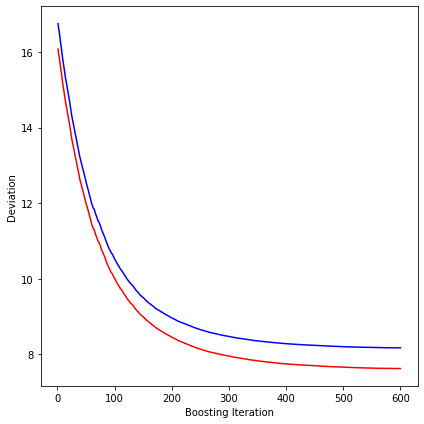

In [38]:
params = {'n_estimators':600}
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
  test_score [i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize = (6,6))
plt.subplot(1, 1, 1)
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-', label = 'Training set Deviation')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label = 'Test set Deviation')
plt.xlabel('Boosting Iteration')
plt.ylabel('Deviation')
fig.tight_layout()
plt.show()

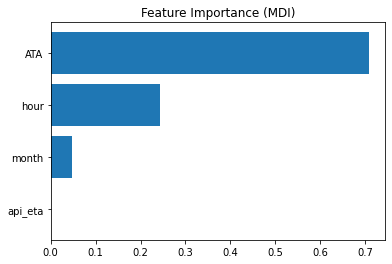

In [39]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(eta_features)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()